In [16]:
import re
import numpy as np
import pandas as pd
import nltk  
nltk.download('stopwords')  
import pickle  
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
  !ls '/content/drive/My Drive/Colab Notebooks/'

 4.4-overfitting-and-underfitting.ipynb.txt
 5.3-using-a-pretrained-convnet.ipynb
 7282_1.csv
 basic_classification.ipynb
 corpus.txt
 Marathi2Vec.ipynb
 NN-example.ipynb
 sample_submission.csv
 test.csv
 Text_Classification_1.ipynb
 text_classification_example.ipynb
 Text_Classification.ipynb
 train.csv
'Transaction Prediction using Deep Learning_1.ipynb'
 Untitled0.ipynb


In [0]:
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/7282_1.csv")

In [0]:
data.head()

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateAdded,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35912 entries, 0 to 35911
Data columns (total 19 columns):
address                 35912 non-null object
categories              35912 non-null object
city                    35912 non-null object
country                 35912 non-null object
latitude                35826 non-null float64
longitude               35826 non-null float64
name                    35912 non-null object
postalCode              35857 non-null object
province                35912 non-null object
reviews.date            35653 non-null object
reviews.dateAdded       35912 non-null object
reviews.doRecommend     0 non-null float64
reviews.id              0 non-null float64
reviews.rating          35050 non-null float64
reviews.text            35890 non-null object
reviews.title           34290 non-null object
reviews.userCity        16263 non-null object
reviews.username        35869 non-null object
reviews.userProvince    17518 non-null object
dtypes: float64(5), 

In [0]:
#Filter out ratings that are zero
data = data[data['reviews.rating']>0]

#Renaming column names that have a '.' in them
data = data.rename(index=str, columns={'reviews.date':'reviewsdate', 'reviews.dateAdded':'reviewsdateAdded',
       'reviews.doRecommend':'reviewsdoRecommend', 'reviews.id':'reviewsid', 'reviews.rating':'reviewsrating', 'reviews.text':'reviewstext',
       'reviews.title':'reviewstitle', 'reviews.userCity':'reviewsuserCity', 'reviews.username':'reviewsusername',
       'reviews.userProvince':'reviewsuserProvince'})
data.reviewstext = data.reviewstext.fillna('x')

#A few hundred ratings had a score above 5, filtering these out
data = data[data['reviewsrating']<=5]

#A few hundred ratings had decimals, rounding each of those down to an integer
data.reviewsrating = data.reviewsrating.astype(int)

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34356 entries, 0 to 35909
Data columns (total 19 columns):
address                34356 non-null object
categories             34356 non-null object
city                   34356 non-null object
country                34356 non-null object
latitude               34289 non-null float64
longitude              34289 non-null float64
name                   34356 non-null object
postalCode             34301 non-null object
province               34356 non-null object
reviewsdate            34312 non-null object
reviewsdateAdded       34356 non-null object
reviewsdoRecommend     0 non-null float64
reviewsid              0 non-null float64
reviewsrating          34356 non-null int64
reviewstext            34356 non-null object
reviewstitle           33717 non-null object
reviewsuserCity        15777 non-null object
reviewsusername        34313 non-null object
reviewsuserProvince    17050 non-null object
dtypes: float64(4), int64(1), object(14)
memor

In [0]:
data.reviewstext[0]

"Pleasant 10 min walk along the sea front to the Water Bus. restaurants etc. Hotel was comfortable breakfast was good - quite a variety. Room aircon didn't work very well. Take mosquito repelant!"

In [0]:
data.reviewsrating.describe()

count    34356.000000
mean         3.759518
std          1.276880
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: reviewsrating, dtype: float64

In [6]:
df=data[['reviewstext','reviewsrating']]
df.head()

,reviewstext,reviewsrating
0,Pleasant 10 min walk along the sea front to th...,4
1,Really lovely hotel. Stayed on the very top fl...,5
2,Ett mycket bra hotell. Det som drog ner betyge...,5
3,We stayed here for four nights in October. The...,5
4,We stayed here for four nights in October. The...,5


In [0]:
df=df.dropna()

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34356 entries, 0 to 35909
Data columns (total 2 columns):
reviewstext      34356 non-null object
reviewsrating    34356 non-null int64
dtypes: int64(1), object(1)
memory usage: 805.2+ KB


## Creating labels from reviews rating

In [0]:
df['labels'] = pd.cut(df['reviewsrating'],3, right=False, labels=["bad", "medium", "good"])

In [9]:
rev = df['labels'].value_counts()
rev.iloc[np.argsort(rev.index)]

bad        6058
medium     5747
good      22551
Name: labels, dtype: int64

In [10]:
df = df[['reviewstext','labels']]
df.head()

,reviewstext,labels
0,Pleasant 10 min walk along the sea front to th...,good
1,Really lovely hotel. Stayed on the very top fl...,good
2,Ett mycket bra hotell. Det som drog ner betyge...,good
3,We stayed here for four nights in October. The...,good
4,We stayed here for four nights in October. The...,good


In [11]:
df.groupby('labels').describe()

reviewstext  ...     
             count  ... freq
labels              ...     
bad           6058  ...    6
medium        5747  ...    4
good         22551  ...   23

[3 rows x 4 columns]

In [12]:
df['length'] = df['reviewstext'].apply(len)
df.head()

,reviewstext,labels,length
0,Pleasant 10 min walk along the sea front to th...,good,194
1,Really lovely hotel. Stayed on the very top fl...,good,252
2,Ett mycket bra hotell. Det som drog ner betyge...,good,136
3,We stayed here for four nights in October. The...,good,354
4,We stayed here for four nights in October. The...,good,354


Let's visualize this! Let's do the imports:

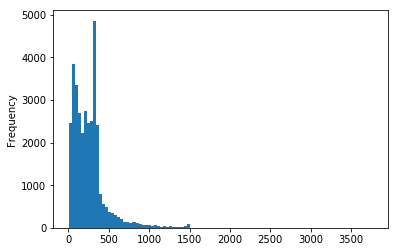

In [0]:
df['length'].plot(bins=100, kind='hist') 

In [0]:
df.length.describe()

count    34356.000000
mean       255.013215
std        218.009275
min          1.000000
25%        102.000000
50%        225.000000
75%        330.000000
max       3772.000000
Name: length, dtype: float64

In [0]:
df[df['length'] == 3772]['reviewstext'].iloc[0]

"Denied access, after fully paid confirmed reservation My problems with this company began in December 2011 when I purchased two Groupon vouchers at 329 each for two nights each. The fine print stated there was an additional fee of 125 for cleaning and insurance per voucher, as well as 12.5 tax. After several days of trying to reach a live person I was able to get a registration clerk who informed me that several of the days I needed were blacked out to Groupon users, as well as certain cabins. This was not listed in the fine print and thus I had to receive a refund on one due to the dates I needed being blacked out. A few days later I called to book for the second voucher and was informed that the additional fees totaled more than 250. I explained what my voucher said, and that my fees should total 181.75 per the Groupon. The clerk refused to budge and also refused to allow me to speak with a member of management, stating, the buck stops with me, if you don't want to pay it, get a ref

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff2bcc6b5f8>,
      dtype=object)

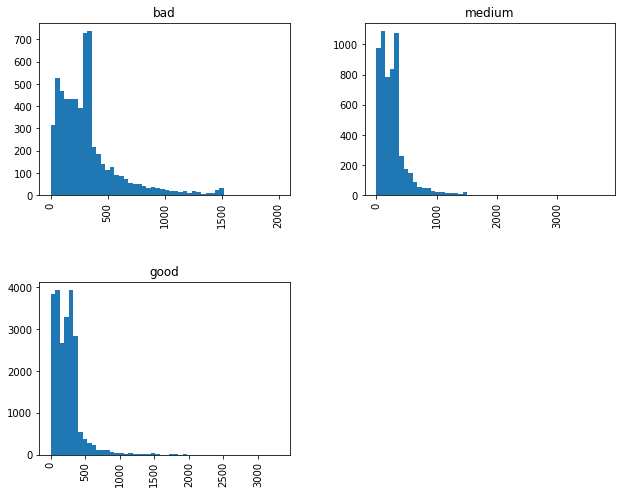

In [0]:
df.hist(column='length', by='labels', bins=50,figsize=(10,8))

## Text Pre-processing

In [0]:
X = df.reviewstext
y = df.labels

In [0]:
documents = []

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):  
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))

    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 

    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)

    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)

    # Converting to Lowercase
    document = document.lower()

    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)

    documents.append(document)

In [0]:
documents[0]

'pleasant 10 min walk along the sea front to the water bus restaurant etc hotel wa comfortable breakfast wa good quite variety room aircon didn work very well take mosquito repelant'

In [0]:
import string

mess = 'Sample message! Notice: it has punctuation.'

# Check characters to see if they are in punctuation
nopunc = [char for char in mess if char not in string.punctuation]

# Join the characters again to form the string.
nopunc = ''.join(nopunc)

In [0]:
nopunc

'Sample message Notice it has punctuation'

In [19]:
stopwords.words('english')[0:10] # Show some stop words

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [0]:
nopunc.split()

['Sample', 'message', 'Notice', 'it', 'has', 'punctuation']

In [0]:
# Now just remove any stopwords
clean_mess = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [0]:
clean_mess

['Sample', 'message', 'Notice', 'punctuation']

In [0]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

Here is the original DataFrame again:

In [21]:
dic = {'reviews_text': documents, 'labels': y}
df1 = pd.DataFrame(dic)
df1.head()

,reviews_text,labels
0,pleasant 10 min walk along the sea front to th...,good
1,really lovely hotel stayed on the very top flo...,good
2,ett mycket bra hotell det som drog ner betyget...,good
3,we stayed here for four night in october the h...,good
4,we stayed here for four night in october the h...,good


In [0]:
# Check to make sure its working
df1['reviews_text'].head(5).apply(text_process)

0    [pleasant, 10, min, walk, along, sea, front, w...
1    [really, lovely, hotel, stayed, top, floor, su...
2    [ett, mycket, bra, hotell, det, som, drog, ner...
3    [stayed, four, night, october, hotel, staff, w...
4    [stayed, four, night, october, hotel, staff, w...
Name: reviews_text, dtype: object

## Vectorization

In [0]:
from sklearn.feature_extraction.text import CountVectorizer  

vectorizer = CountVectorizer(analyzer=text_process).fit(df1['reviews_text'])

In [23]:
len(vectorizer.vocabulary_)

29110

In [24]:
review6 = X[5]
print(review6)

We loved staying on the island of Lido! You need to take a water is from Venice to get there. From the train station, a boat ride takes 45 minutes but has beautiful views along the way. Hotel is an EASY walk from the boat dock. The room was very clean and the breakfast was plentiful. We would definitely recommend this hotel!


In [25]:
bow6 = vectorizer.transform([review6])
print(bow6)
print(bow6.shape)

  (0, 620)	1
  (0, 1657)	1
  (0, 3186)	1
  (0, 3752)	2
  (0, 4000)	1
  (0, 5364)	1
  (0, 7140)	1
  (0, 7960)	1
  (0, 11207)	1
  (0, 12581)	1
  (0, 13679)	1
  (0, 15359)	1
  (0, 17169)	1
  (0, 19364)	1
  (0, 20868)	1
  (0, 21695)	1
  (0, 21919)	1
  (0, 24322)	1
  (0, 24348)	1
  (0, 25152)	1
  (0, 26109)	1
  (0, 27972)	1
  (0, 28077)	1
  (0, 28115)	1
  (0, 28590)	1
(1, 29110)


In [26]:
print(vectorizer.get_feature_names()[3186])
print(vectorizer.get_feature_names()[28115])

beautiful
way


In [0]:
reviews_bow = vectorizer.transform(df1['reviews_text'])

In [28]:
print('Shape of Sparse Matrix: ', reviews_bow.shape)
print('Amount of Non-Zero occurences: ', reviews_bow.nnz)

Shape of Sparse Matrix:  (34356, 29110)
Amount of Non-Zero occurences:  787355


In [29]:
sparsity = (100.0 * reviews_bow.nnz / (reviews_bow.shape[0] * reviews_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))
print('sparsity: {}'.format(sparsity))

sparsity: 0
sparsity: 0.07872737848363563


In [30]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidfconverter = TfidfTransformer().fit(reviews_bow)

tfidf6 = tfidfconverter.transform(bow6)
print(tfidf6)

  (0, 28590)	0.10484360612456795
  (0, 28115)	0.1482918082741142
  (0, 28077)	0.15735462914956574
  (0, 27972)	0.15679284129881893
  (0, 26109)	0.21230660353636258
  (0, 25152)	0.16814523412237894
  (0, 24348)	0.15501109587929324
  (0, 24322)	0.19798963587559268
  (0, 21919)	0.06157189779420627
  (0, 21695)	0.22261799351806624
  (0, 20868)	0.1468570522444371
  (0, 19364)	0.2604622575207621
  (0, 17169)	0.13593857324798087
  (0, 15359)	0.16340841215572943
  (0, 13679)	0.2577378201909935
  (0, 12581)	0.0696352076462287
  (0, 11207)	0.12511112710454098
  (0, 7960)	0.297993325558555
  (0, 7140)	0.1477590071900157
  (0, 5364)	0.08477141051851446
  (0, 4000)	0.09029782032995437
  (0, 3752)	0.5056869464463525
  (0, 3186)	0.15645383165990084
  (0, 1657)	0.20575378436104128
  (0, 620)	0.2402573499756617


In [31]:
reviews_tfidf = tfidfconverter.transform(reviews_bow)
print(reviews_tfidf.shape)

(34356, 29110)


## Training a model

In [0]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB().fit(reviews_tfidf, df1['labels'])

Let's try classifying our single random message and checking how we do:

In [33]:
print('predicted:', nb.predict(tfidf6)[0])
print('expected:', y[1])

predicted: good
expected: good


## Model Evaluation

In [34]:
all_predictions = nb.predict(reviews_tfidf)
print(all_predictions)

['good' 'good' 'good' ... 'good' 'good' 'good']


In [35]:
from sklearn.metrics import classification_report
print (classification_report(df1['labels'], all_predictions))

              precision    recall  f1-score   support

         bad       0.83      0.43      0.57      6058
        good       0.72      0.99      0.83     22551
      medium       0.58      0.04      0.08      5747

    accuracy                           0.73     34356
   macro avg       0.71      0.49      0.49     34356
weighted avg       0.72      0.73      0.66     34356



## Train Test Split

In [0]:
mapping_dict = {'labels': {'bad': 0, 'medium': 1, 'good': 2}}

In [0]:
df1.replace(mapping_dict, inplace=True)

In [38]:
len(df1)

34356

In [0]:
from sklearn.model_selection import train_test_split

X = df1.reviews_text
y = df1.labels

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(binary=True)

X_train_vect = vect.fit_transform(X_train)

In [58]:
X_train_vect

<25767x25323 sparse matrix of type '<class 'numpy.int64'>'
	with 883017 stored elements in Compressed Sparse Row format>

In [0]:
#@title Over Sampling


In [0]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()

X_train_res, y_train_res = sm.fit_sample(X_train_vect, y_train)

In [60]:
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))

[(0, 16922), (1, 16922), (2, 16922)]


## Applying NB Model


In [61]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB(alpha = 0.1)

nb.fit(X_train_res, y_train_res)

nb.score(X_train_res, y_train_res)

0.7247567269432297

In [62]:
X_test_vect = vect.transform(X_test)

y_pred = nb.predict(X_test_vect)

y_pred

array([2, 1, 2, ..., 2, 2, 2])

In [64]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

print("Train Accuracy: {:.2f}%".format(accuracy_score(y_train_res, nb.predict(X_train_res)) * 100))
print("Test Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Train Accuracy: 72.48%
Test Accuracy: 68.49%

Confusion Matrix:
 [[1107  249  175]
 [ 412  544  473]
 [ 359 1038 4232]]


In [65]:
print(nb.predict(vect.transform(['dirty rooms and beds are not align'])))

[0]


In [66]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.59      0.72      0.65      1531
           1       0.30      0.38      0.33      1429
           2       0.87      0.75      0.81      5629

    accuracy                           0.68      8589
   macro avg       0.58      0.62      0.60      8589
weighted avg       0.72      0.68      0.70      8589



In [0]:
#@title Under Sampling


In [0]:
from imblearn.under_sampling import NearMiss

nr = NearMiss()
X_train_nr, y_train_nr = nr.fit_sample(X_train_vect, y_train)

In [68]:
unique, counts = np.unique(y_train_nr, return_counts=True)
print(list(zip(unique, counts)))

[(0, 4318), (1, 4318), (2, 4318)]


In [0]:
#@title ## Applying NB Model

In [69]:
nb.fit(X_train_nr, y_train_nr)

nb.score(X_train_nr, y_train_nr)

0.8126447429365447

In [70]:
y_pred = nb.predict(X_test_vect)

y_pred

array([2, 1, 1, ..., 2, 1, 1])

In [71]:
print("Train Accuracy: {:.2f}%".format(accuracy_score(y_train_nr, nb.predict(X_train_nr)) * 100))
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Train Accuracy: 81.26%
Accuracy: 49.32%

Confusion Matrix:
 [[1061  409   61]
 [ 396  805  228]
 [ 476 2783 2370]]


In [72]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.55      0.69      0.61      1531
           1       0.20      0.56      0.30      1429
           2       0.89      0.42      0.57      5629

    accuracy                           0.49      8589
   macro avg       0.55      0.56      0.49      8589
weighted avg       0.72      0.49      0.53      8589



In [0]:
#@title ## Applying LinearSVC model


In [0]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

#pipeline of feature engineering and model
model = Pipeline([('vectorizer', CountVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('clf', LinearSVC(class_weight='balanced'))])
#the class_weight="balanced" option tries to remove the biasedness of model towards majority sample

In [74]:
#paramater selection
from sklearn.model_selection import GridSearchCV
parameters = {'vectorizer__ngram_range': [(1, 1), (1, 2),(2,2)],
               'tfidf__use_idf': (True, False)}

gs_clf_svm = GridSearchCV(model, parameters, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(X, y)

print(gs_clf_svm.best_score_)
print(gs_clf_svm.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.7522994527884503
{'tfidf__use_idf': False, 'vectorizer__ngram_range': (1, 2)}


In [0]:
#preparing the final pipeline using the selected parameters
model = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1,2))),
    ('tfidf', TfidfTransformer(use_idf=False)),
    ('clf', LinearSVC(class_weight="balanced"))])

In [0]:
#fit model with training data
model.fit(X_train, y_train)

pred = model.predict(X_test)

In [78]:
print("Train Accuracy: {:.2f}%".format(accuracy_score(y_train, model.predict(X_train)) * 100))
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, pred) * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, pred))

Train Accuracy: 96.18%
Accuracy: 76.81%

Confusion Matrix:
 [[1101  234  196]
 [ 356  463  610]
 [ 188  408 5033]]


In [79]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.67      0.72      0.69      1531
           1       0.42      0.32      0.37      1429
           2       0.86      0.89      0.88      5629

    accuracy                           0.77      8589
   macro avg       0.65      0.65      0.65      8589
weighted avg       0.75      0.77      0.76      8589



In [0]:
#@title ## Model Selection with Over Sampling


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


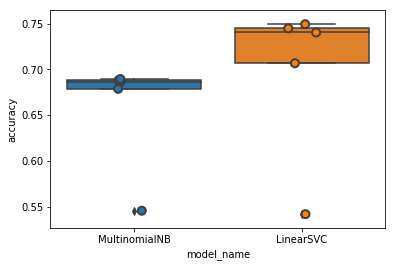

In [80]:
from sklearn.model_selection import cross_val_score
models = [
    MultinomialNB(),
    LinearSVC()
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_train_res, y_train_res, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [81]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC        0.696656
MultinomialNB    0.657729
Name: accuracy, dtype: float64

In [0]:
#@title ## Model Evaluation of LinearSVC with Over Sampling


In [82]:
model = LinearSVC()
model.fit(X_train_res, y_train_res)
y_pred = model.predict(X_test_vect)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [84]:
print("Train Accuracy: {:.2f}%".format(accuracy_score(y_train_res, model.predict(X_train_res)) * 100))
print(" Test Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Train Accuracy: 83.00%
 Test Accuracy: 67.02%

COnfusion Matrix:
 [[ 924  317  290]
 [ 341  495  593]
 [ 346  946 4337]]


In [85]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.60      0.59      1531
           1       0.28      0.35      0.31      1429
           2       0.83      0.77      0.80      5629

    accuracy                           0.67      8589
   macro avg       0.56      0.57      0.57      8589
weighted avg       0.69      0.67      0.68      8589



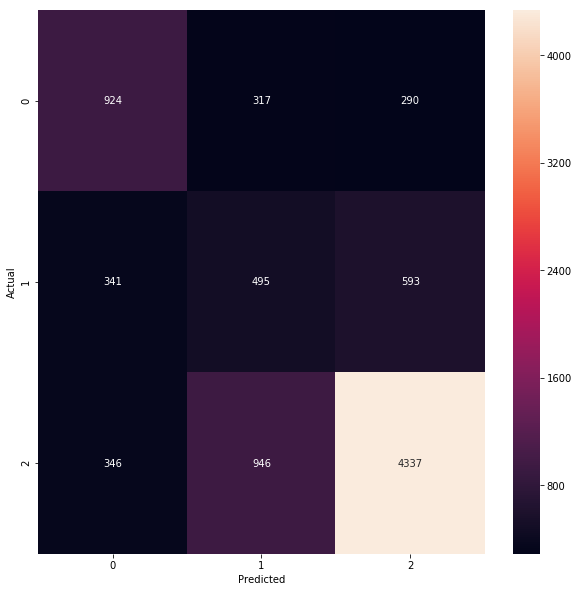

In [86]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [0]:
#@title ## Model Evaluation of LinearSVC with Under Sampling


In [87]:
model = LinearSVC()
model.fit(X_train_nr, y_train_nr)
y_pred = model.predict(X_test_vect)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [88]:
print("Train Accuracy: {:.2f}%".format(accuracy_score(y_train_nr, model.predict(X_train_nr)) * 100))
print(" Test Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Train Accuracy: 93.72%
 Test Accuracy: 48.64%

COnfusion Matrix:
 [[ 965  447  119]
 [ 393  746  290]
 [ 742 2420 2467]]


In [89]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.63      0.53      1531
           1       0.21      0.52      0.30      1429
           2       0.86      0.44      0.58      5629

    accuracy                           0.49      8589
   macro avg       0.51      0.53      0.47      8589
weighted avg       0.68      0.49      0.52      8589



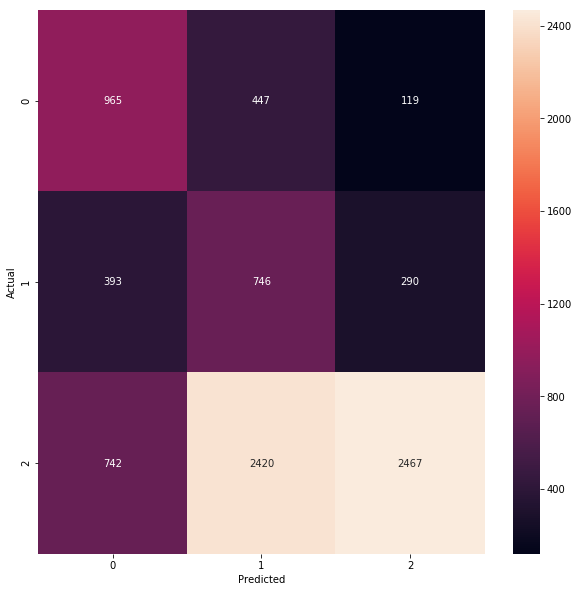

In [90]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()